Predicting UP IR flux, large errors using very bad method (let's see if this performs worse than 3.3.1)

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
DS_a = xr.open_dataset('af') #dataset of auxhist
DS_w = xr.open_dataset('wf') #dataset of wrfout

In [3]:
#Temperature:
T = (DS_w.T.values + DS_w.T0) * ((DS_w.P.values + DS_w.PB.values)/DS_w.P0)**(DS_w.R_D/DS_w.CP)
T.shape

(71, 52, 36, 72)

In [4]:
T[5,:,18,0] #temperature goes from lowest height to highest height

array([242.71082 , 237.8069  , 236.24007 , 235.12848 , 234.2799  ,
       233.52779 , 232.82172 , 232.14073 , 231.47406 , 230.81564 ,
       229.99742 , 229.01949 , 228.03973 , 227.05513 , 225.73048 ,
       224.05423 , 220.9039  , 215.62561 , 209.97517 , 208.85222 ,
       206.90262 , 204.41917 , 200.12592 , 195.17355 , 189.94121 ,
       186.28903 , 183.58492 , 180.31416 , 176.13753 , 171.68274 ,
       167.32304 , 163.81029 , 160.24342 , 155.59138 , 150.58986 ,
       146.3529  , 142.94057 , 139.79279 , 136.59853 , 133.4877  ,
       131.82347 , 138.27815 , 160.04852 , 173.36342 , 169.7645  ,
       162.5508  , 155.04514 , 147.05397 , 139.96574 , 138.28108 ,
       119.210464, 138.57014 ], dtype=float32)

In [5]:
st = DS_w.TSK.values #surface temp
st.shape

(71, 36, 72)

In [6]:
d_c = DS_w.TAU_OD.values #dust optical depth
d_c.shape 

(71, 52, 36, 72)

In [7]:
em = DS_w.EMISS.values #emissivity
em.shape

(71, 36, 72)

In [8]:
uif = DS_a.UPIRFLUX.values[1:,10,:,:] #remove 1st snapshot since it contains all 0s
uif.shape

(70, 36, 72)

In [9]:
t_d = [] #total data
#input:
for k in range(1,71): #go through all data, ignore 1st time snapshot since that is removed from uif as well
    for i in range(36):
        for j in range(72):
            input_array = list(T[k,:,i,j]) #start with temp profile
            input_array += list(d_c[k,:,i,j]) #add dust profile
            input_array.append(st[k,i,j])#add surface temp
            input_array.append(em[k,i,j]) #add emissivity
            input_array.append(uif[k-1,i,j])            
            t_d.append(input_array) #appends input to input array

In [10]:
t_d = np.array(t_d)
t_d.shape

(181440, 107)

In [11]:
uif_in = t_d[:,:106]
uif_out = t_d[:,106]

In [12]:
np.array_equal(uif[:,:,:].reshape(-1), t_d[:,106])

True

In [13]:
t_d[:,106].shape

(181440,)

# Trying linear regression first

In [14]:
from sklearn.linear_model import LinearRegression
lr1 = LinearRegression()
lr1.fit(uif_in,uif_out)
uif_lin = lr1.predict(uif_in) #predicted

In [15]:
lr1.coef_

array([ 5.5706614e-01, -1.3727704e+00,  1.5506542e-01,  2.3519397e-03,
        4.6444163e-02,  1.4692729e+00, -3.4386659e-01, -1.4486345e+00,
        1.4234892e-01,  1.0116982e+00,  6.8932182e-01, -2.3221235e+00,
        4.8593836e+00, -4.4601240e+00, -3.7048563e-01,  4.3186593e+00,
       -2.1373515e+00, -2.0056558e-01,  9.3532324e-01, -1.6429627e+00,
       -1.7446852e+00,  1.0467234e+00,  8.8254452e-01, -9.3088531e-01,
       -1.2881517e+00,  2.5847168e+00, -3.3010206e+00,  4.6495895e+00,
       -4.2098007e+00,  3.2827301e+00, -3.1775589e+00,  2.9616394e+00,
       -2.1660080e+00,  1.1511459e+00, -3.2394695e-01,  6.3802528e-01,
       -4.7572327e-01, -2.0342255e-01,  4.4356441e-01, -5.8035278e-01,
        4.7495842e-01, -1.5881538e-01,  1.1653900e-01, -4.2298603e-01,
        4.5926571e-01, -3.2404518e-01,  1.3963604e-01,  2.3614693e-01,
       -4.0736294e-01,  4.5803642e-01, -3.1065750e-01,  4.2423463e-01,
        1.6623932e+04,  1.4674341e+04,  1.1753401e+04,  6.9616421e+03,
      

In [16]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse #a lot higher!

17.608517

In [17]:
np.min(uif_out)

15.638899

In [18]:
np.max(uif_out)

412.3086

In [19]:
uif_diff = uif_out - uif_lin

In [20]:
np.where(uif_diff == np.min(uif_diff))

(array([119938], dtype=int64),)

In [21]:
uif_out[1265]

43.645775

In [22]:
uif_lin[1265] #reall pretty big differences...

13.552948

In [23]:
np.where(uif_diff > 50)

(array([  6633,   9225,  26543, ..., 175113, 177705, 180297], dtype=int64),)

<function matplotlib.pyplot.show(*args, **kw)>

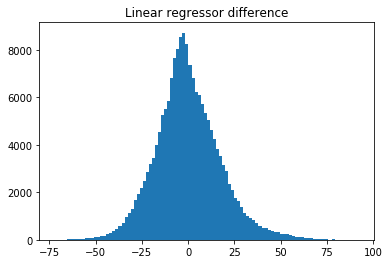

In [24]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #much larger variance than before...

In [25]:
uif_out.reshape(-1,1).shape

(181440, 1)

In [26]:
uif_in[:10*36*72,:].shape

(25920, 106)

In [27]:
uif_in[10*36*72:11*36*72,:]

array([[1.4630409e+02, 1.4639401e+02, 1.4629814e+02, ..., 2.0631052e-09,
        1.4549599e+02, 7.3600000e-01],
       [1.4631259e+02, 1.4640625e+02, 1.4631282e+02, ..., 2.0644766e-09,
        1.4550348e+02, 7.3600000e-01],
       [1.4631487e+02, 1.4641173e+02, 1.4632056e+02, ..., 2.0649937e-09,
        1.4550633e+02, 7.3600000e-01],
       ...,
       [2.0453691e+02, 2.0465752e+02, 2.0457433e+02, ..., 3.0792648e-09,
        2.0332706e+02, 1.0000000e+00],
       [2.0481697e+02, 2.0492590e+02, 2.0483357e+02, ..., 3.0799232e-09,
        2.0364990e+02, 1.0000000e+00],
       [2.0508966e+02, 2.0518651e+02, 2.0508461e+02, ..., 3.0805007e-09,
        2.0396954e+02, 1.0000000e+00]], dtype=float32)

In [28]:
real_out = uif_out[10*36*72:11*36*72].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72].reshape(36,72)

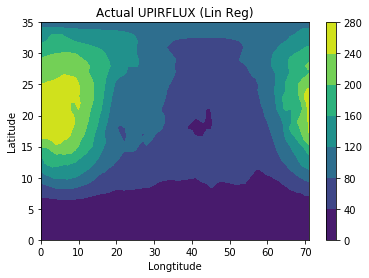

In [29]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

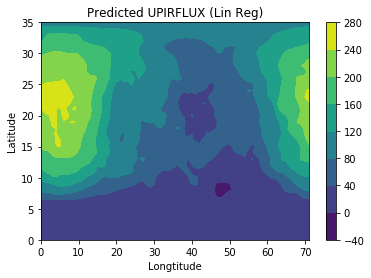

In [30]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

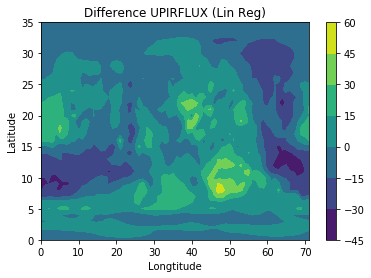

In [31]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

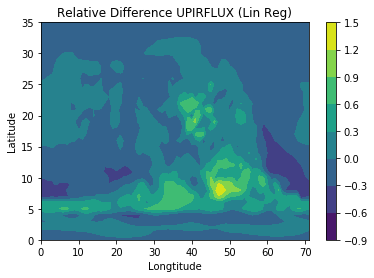

In [32]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [33]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [34]:
real_out.shape

(36, 72)

In [36]:
lin_int_err = int_err(uif_lin, uif_out, pd.DataFrame(uif_lin), 3.39e6) #make sure the errors work by integrating a sphere's surface
print("Linear regression integration error:")
np.array(lin_int_err)/(1.44e14)/70 #this isn't very large, but the plots indicate that this prediction method is indeed faulty

Linear regression integration error:


0.23770116450310885